# **Chapter 5 - The Neuron**

### **Imports**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

### **Data Generation**

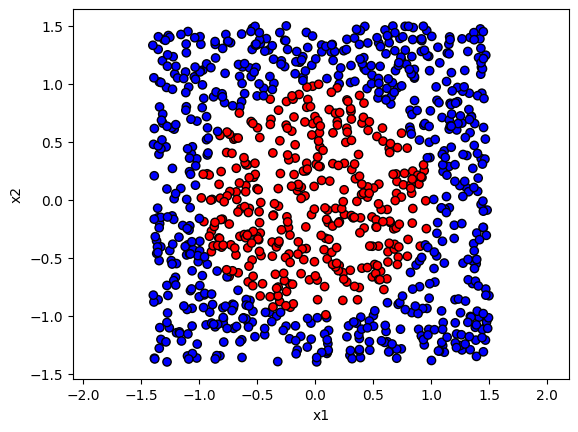

In [2]:
# Generate synthetic data: points in 2D
np.random.seed(0)
N = 1000
X_train = np.random.uniform(-1.4, 1.5, (N, 2))  # points in [-1.5, 1.5] square
X_test = np.random.uniform(-1.5, 1.5, (N//8, 2))
# Labels: inside circle radius=1 -> class 1, else 0
y_train = (X_train[:,0]**2 + X_train[:,1]**2 <= 1.0).astype(int)
y_test = (X_test[:,0]**2 + X_test[:,1]**2 <= 1.0).astype(int)

# Visualize data
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap="bwr", edgecolor="k")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

## **Single Neuron**

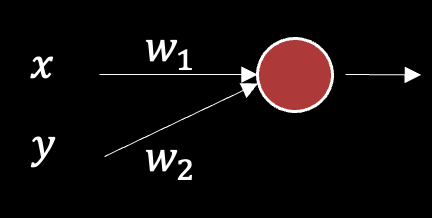

Lets define a single neuron with input of 2 - $(x,y)$

Let us use the sigmoid activation: $\sigma(x) = \frac{1}{1+e^{-x}}$

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Initialize weights and bias
w = np.random.randn(2)
b = 0.0

## initalize the step size (learning rate)
lr = 0.1
epochs = 50

**Training**

Let's train the neuron using Gradient Descend

In [6]:
for epoch in range(epochs):
    # Linear combination
    z = np.dot(X_train, w) + b
    y_pred = sigmoid(z)

    # Binary cross-entropy loss
    loss = -np.mean(y_train*np.log(y_pred+1e-8) + (1-y_train)*np.log(1-y_pred+1e-8))

    # Gradients
    grad_w = np.dot(X_train.T, (y_pred - y_train)) / N
    grad_b = np.mean(y_pred - y_train)

    # Update
    w -= lr * grad_w
    b -= lr * grad_b

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss = {loss:.4f}")

Epoch 0, Loss = 0.7182
Epoch 20, Loss = 0.6734
Epoch 40, Loss = 0.6543


**Decision Boundary**

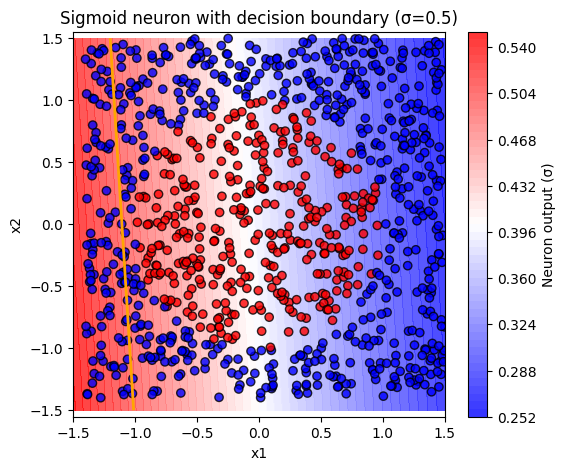

In [7]:
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 200),
                     np.linspace(-1.5, 1.5, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)
zz = sigmoid(np.dot(grid, w) + b).reshape(xx.shape)

# --- Plot sigmoid outputs over the grid ---
plt.figure(figsize=(6,5))
# Heatmap of sigmoid output
plt.contourf(xx, yy, zz, levels=50, cmap="bwr", alpha=0.8)
plt.colorbar(label="Neuron output (σ)")

# Decision boundary where σ = 0.5
plt.contour(xx, yy, zz, levels=[0,0.5,1], colors="orange", linewidths=2)

# Overlay training data
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap="bwr", edgecolor="k", alpha=0.8)

plt.title("Sigmoid neuron with decision boundary (σ=0.5)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()



## **Three Neurons**


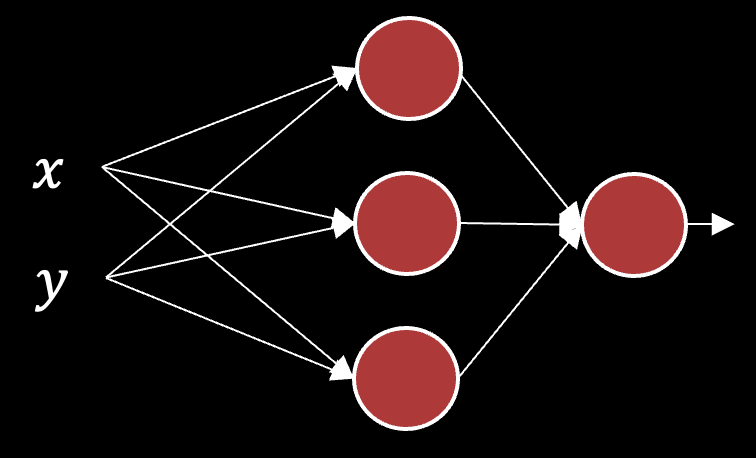


Single neuron can't separate by curved decision boundary - lets try with 3 neurons!

Epoch 0, Train Loss = 0.6663
Epoch 0, Test Loss = 0.6647
Epoch 500, Train Loss = 0.6428
Epoch 500, Test Loss = 0.6428
Epoch 1000, Train Loss = 0.6400
Epoch 1000, Test Loss = 0.6400
Epoch 1500, Train Loss = 0.6363
Epoch 1500, Test Loss = 0.6363
Epoch 2000, Train Loss = 0.6301
Epoch 2000, Test Loss = 0.6301
Epoch 2500, Train Loss = 0.6210
Epoch 2500, Test Loss = 0.6209
Epoch 3000, Train Loss = 0.6099
Epoch 3000, Test Loss = 0.6098
Epoch 3500, Train Loss = 0.5967
Epoch 3500, Test Loss = 0.5967
Epoch 4000, Train Loss = 0.5793
Epoch 4000, Test Loss = 0.5792
Epoch 4500, Train Loss = 0.5535
Epoch 4500, Test Loss = 0.5535
Epoch 5000, Train Loss = 0.5184
Epoch 5000, Test Loss = 0.5183
Epoch 5500, Train Loss = 0.4855
Epoch 5500, Test Loss = 0.4854
Epoch 6000, Train Loss = 0.4654
Epoch 6000, Test Loss = 0.4654
Epoch 6500, Train Loss = 0.4549
Epoch 6500, Test Loss = 0.4548
Epoch 7000, Train Loss = 0.4486
Epoch 7000, Test Loss = 0.4486
Epoch 7500, Train Loss = 0.4440
Epoch 7500, Test Loss = 0.4440


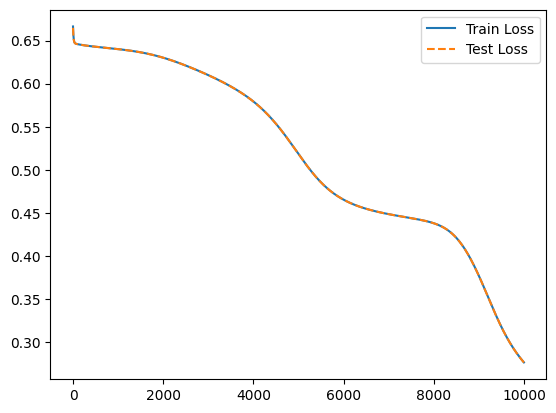

In [8]:
# Convert to torch tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

# ---- Define single-layer model: Logistic regression ----
class SingleNeuron(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 3)
        self.linear2 = nn.Linear(3, 1)   # just one linear neuron
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.linear2(self.activation(self.linear(x))))

model = SingleNeuron()

# ---- Training setup ----
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
train_losses = []
test_losses = []

# ---- Training loop ----
for epoch in range(10000):

    y_pred = model(X_tensor)

    loss = criterion(y_pred, y_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Train Loss = {loss.item():.4f}")

    with torch.no_grad():
      model.eval()
      y_pred = model(X_tensor)
      loss = criterion(y_pred, y_tensor)
      if epoch % 500 == 0:
        print(f"Epoch {epoch}, Test Loss = {loss.item():.4f}")
      test_losses.append(loss.item())

    model.train()


plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss", linestyle="--")
plt.legend()
plt.show()

**Plot the Decision Boundary**

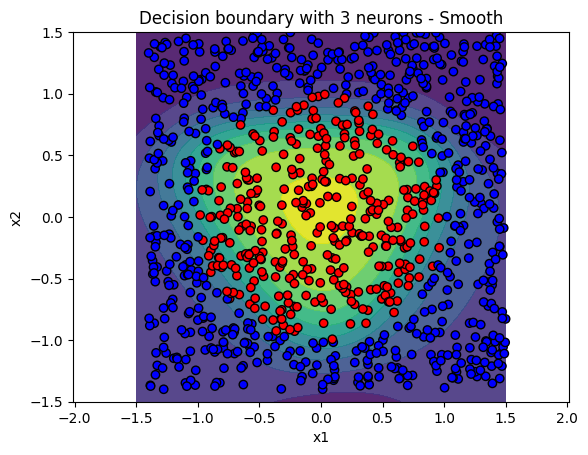

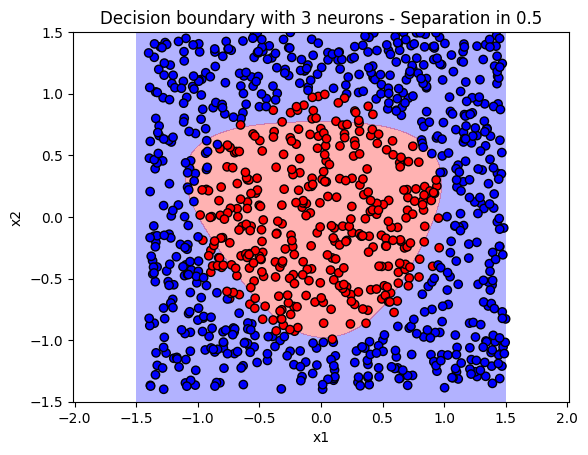

In [9]:
# ---- Plot decision boundary ----
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 200),
                     np.linspace(-1.5, 1.5, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)
zz = model(grid_tensor).detach().numpy().reshape(xx.shape)

plt.contourf(xx, yy, zz, levels=10, alpha=0.9)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap="bwr", edgecolor="k")
plt.title("Decision boundary with 3 neurons - Smooth")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

plt.contourf(xx, yy, zz, levels=[0,0.5,1], alpha=0.3, colors=["blue", "red"])
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap="bwr", edgecolor="k")
plt.title("Decision boundary with 3 neurons - Separation in 0.5")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

Validate model

Loss = 0.2847


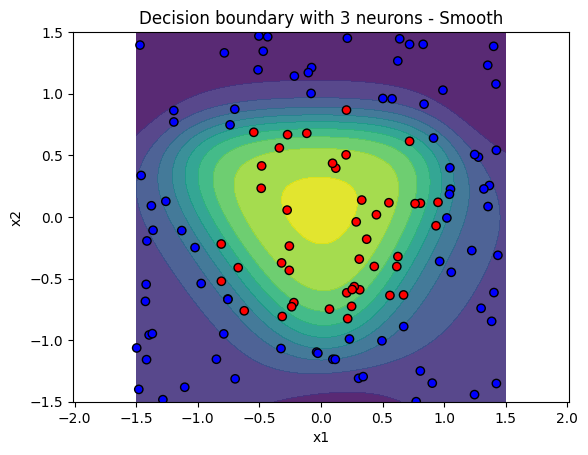

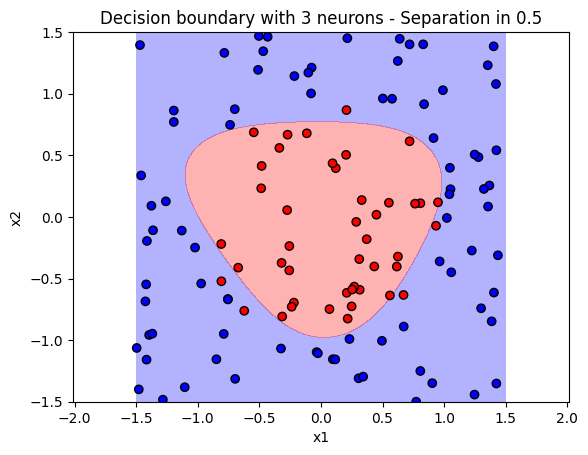

In [10]:
# Convert to torch tensors
X_tensor_test = torch.tensor(X_test, dtype=torch.float32)
y_tensor_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


# ---- Training setup ----
criterion = nn.BCELoss()

# ---- Training loop ----
model.eval()
with torch.no_grad():
    y_pred = model(X_tensor_test)
    loss = criterion(y_pred, y_tensor_test)
    print(f"Loss = {loss.item():.4f}")


# ---- Plot decision boundary ----
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 200),
                     np.linspace(-1.5, 1.5, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)
zz = model(grid_tensor).detach().numpy().reshape(xx.shape)

plt.contourf(xx, yy, zz, levels=10, alpha=0.9)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap="bwr", edgecolor="k")
plt.title("Decision boundary with 3 neurons - Smooth")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

plt.contourf(xx, yy, zz, levels=[0,0.5,1], alpha=0.3, colors=["blue", "red"])
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap="bwr", edgecolor="k")
plt.title("Decision boundary with 3 neurons - Separation in 0.5")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

**View Single Neurons**

Lets see the decision boundary created by each neuron

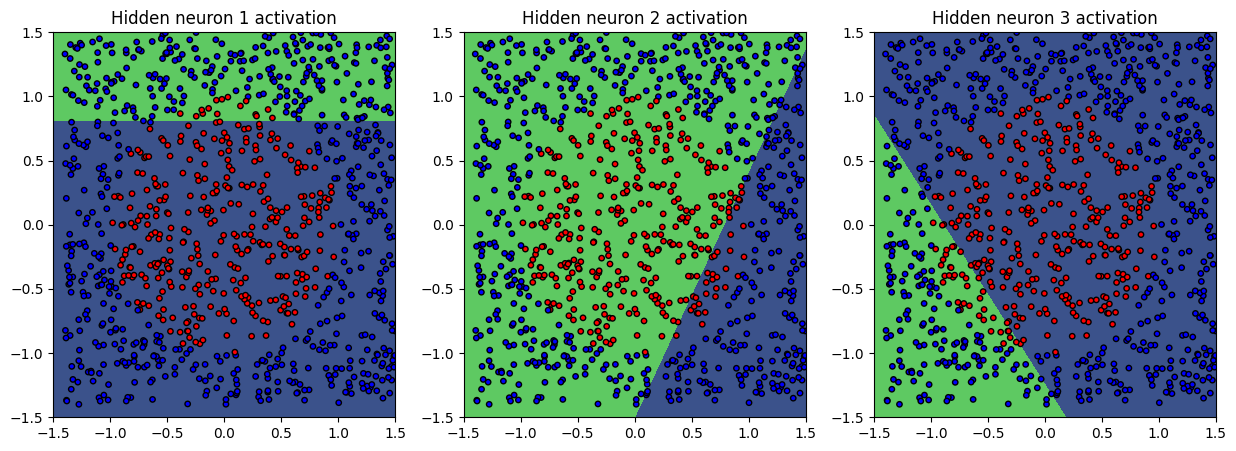

In [11]:
# --- Evaluate hidden neurons ---
with torch.no_grad():
    hidden_output = model.activation(model.linear(X_tensor))  # shape: (N, 3)

# Plot each hidden neuron’s activation across input space
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    # Create a grid for visualization
    xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 200),
                         np.linspace(-1.5, 1.5, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Pass through the hidden layer only
    hidden_vals = model.activation(model.linear(grid_tensor))[:, i].detach().numpy().reshape(xx.shape)

    im = axes[i].contourf(xx, yy, hidden_vals, levels=1, cmap='viridis')
    axes[i].scatter(X_train[:,0], X_train[:,1], c=y_train, cmap="bwr", edgecolor='k', s=15)
    axes[i].set_title(f"Hidden neuron {i+1} activation")
plt.show()


## **Multiple Neurons**


We see 3 neurons get us closer for a good solution, lets try with multiple neurons to get even closer.

Set number of neurons to 50.

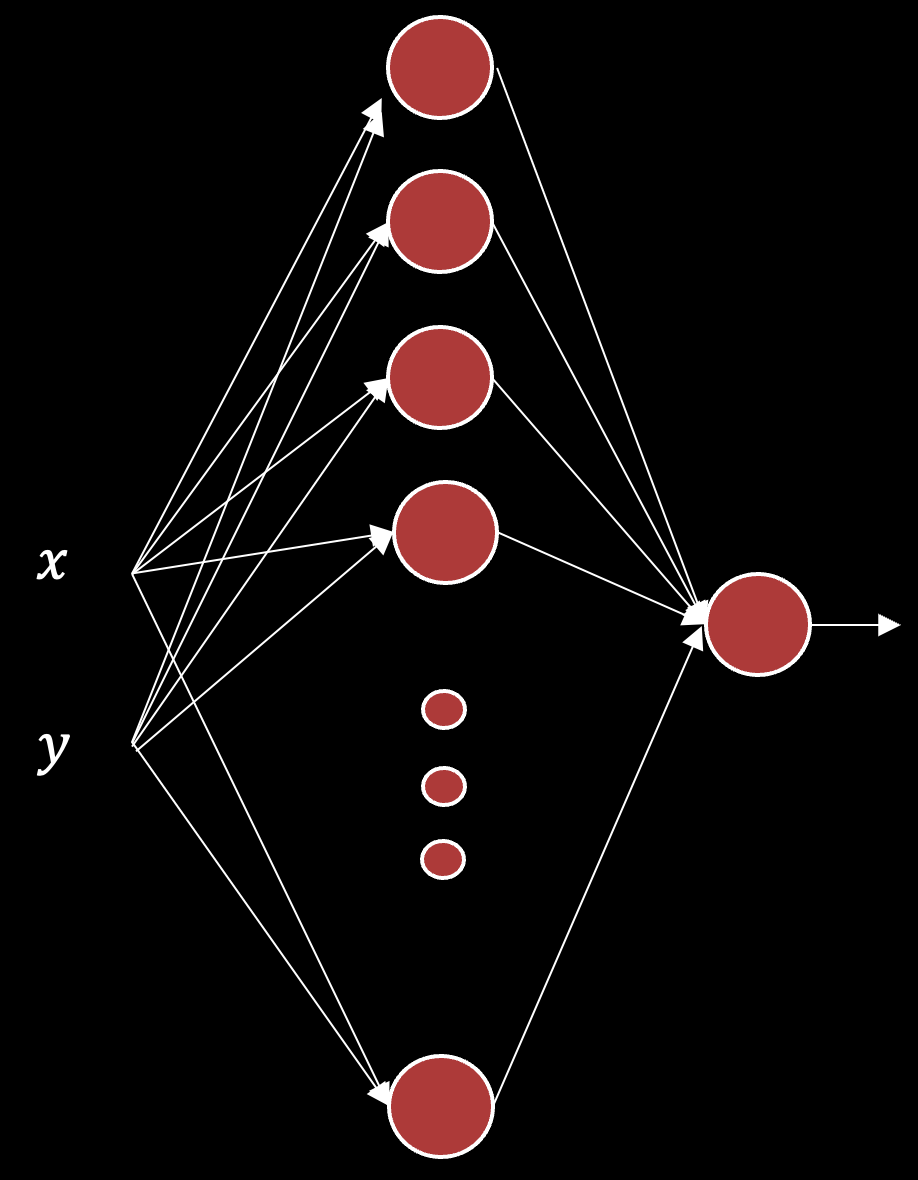



In [12]:
# Convert to torch tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

# ---- Define single-layer model: Logistic regression ----
class SingleNeuron(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 50)
        self.linear2 = nn.Linear(50, 1)   # just one linear neuron
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.linear2(self.activation(self.linear(x))))

model = SingleNeuron()

# ---- Training setup ----
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# ---- Training loop ----
for epoch in range(10000):

    y_pred = model(X_tensor)

    loss = criterion(y_pred, y_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.4f}")


Epoch 0, Loss = 0.6749
Epoch 500, Loss = 0.6339
Epoch 1000, Loss = 0.6272
Epoch 1500, Loss = 0.6134
Epoch 2000, Loss = 0.5819
Epoch 2500, Loss = 0.5153
Epoch 3000, Loss = 0.4134
Epoch 3500, Loss = 0.3145
Epoch 4000, Loss = 0.2475
Epoch 4500, Loss = 0.2054
Epoch 5000, Loss = 0.1772
Epoch 5500, Loss = 0.1571
Epoch 6000, Loss = 0.1420
Epoch 6500, Loss = 0.1304
Epoch 7000, Loss = 0.1210
Epoch 7500, Loss = 0.1134
Epoch 8000, Loss = 0.1070
Epoch 8500, Loss = 0.1016
Epoch 9000, Loss = 0.0969
Epoch 9500, Loss = 0.0928


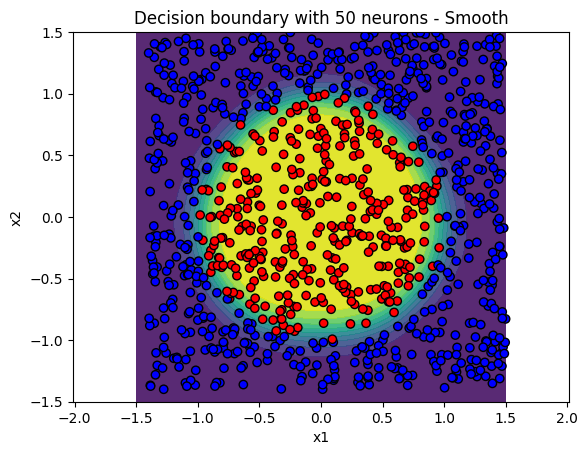

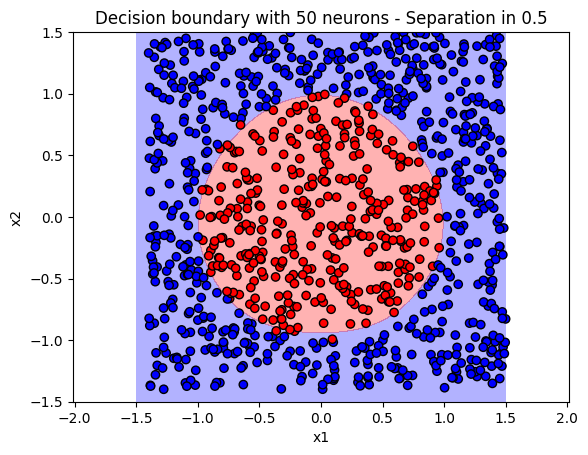

In [16]:
# ---- Plot decision boundary ----
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 200),
                     np.linspace(-1.5, 1.5, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)
zz = model(grid_tensor).detach().numpy().reshape(xx.shape)

plt.contourf(xx, yy, zz, levels=10, alpha=0.9)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap="bwr", edgecolor="k")
plt.title("Decision boundary with 50 neurons - Smooth")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

plt.contourf(xx, yy, zz, levels=[0,0.5,1], alpha=0.3, colors=["blue", "red"])
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap="bwr", edgecolor="k")
plt.title("Decision boundary with 50 neurons - Separation in 0.5")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

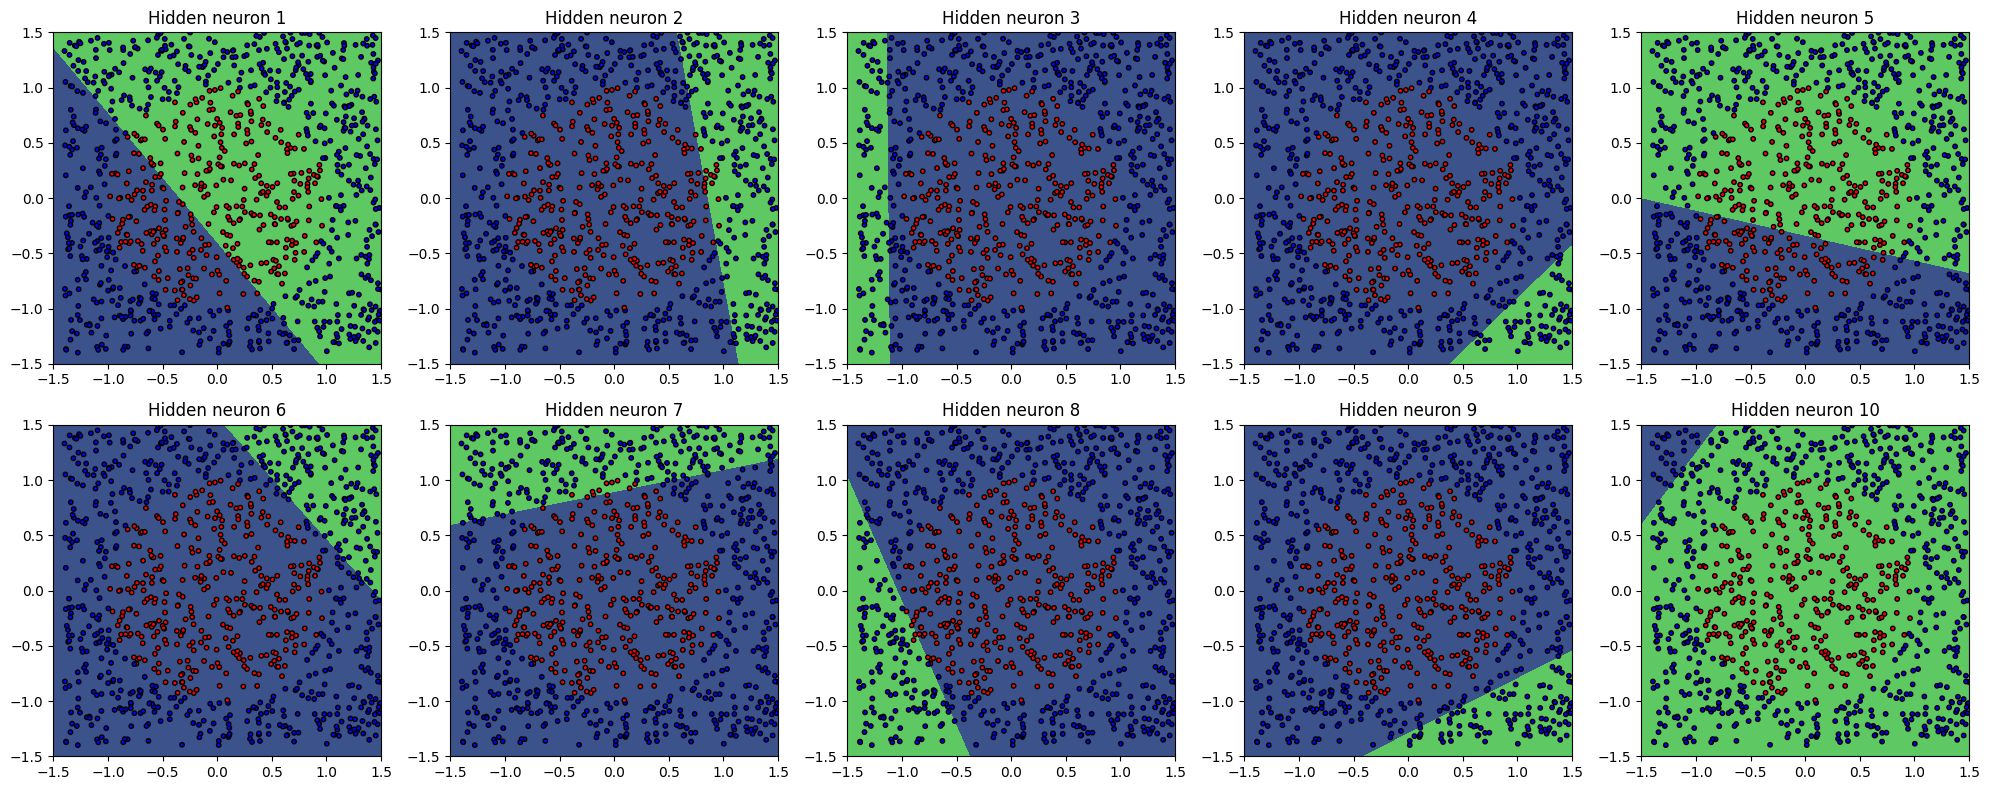

In [17]:
# --- Evaluate hidden neurons ---
with torch.no_grad():
    hidden_output = model.activation(model.linear(X_tensor))  # shape: (N, hidden_dim)

num_neurons = 10
rows, cols = 2, 5  # layout for 10 neurons
fig, axes = plt.subplots(rows, cols, figsize=(20, 8))

for i in range(num_neurons):
    ax = axes[i // cols, i % cols]  # pick correct subplot

    # Create a grid for visualization
    xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 200),
                         np.linspace(-1.5, 1.5, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Pass through the hidden layer only
    hidden_vals = model.activation(model.linear(grid_tensor))[:, i].detach().numpy().reshape(xx.shape)

    im = ax.contourf(xx, yy, hidden_vals, levels=0, cmap='viridis')
    ax.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap="bwr", edgecolor='k', s=10)
    ax.set_title(f"Hidden neuron {i+1}")

# fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.04)
plt.tight_layout()
plt.show()


##  **Two Neurons in Hidden Layer**

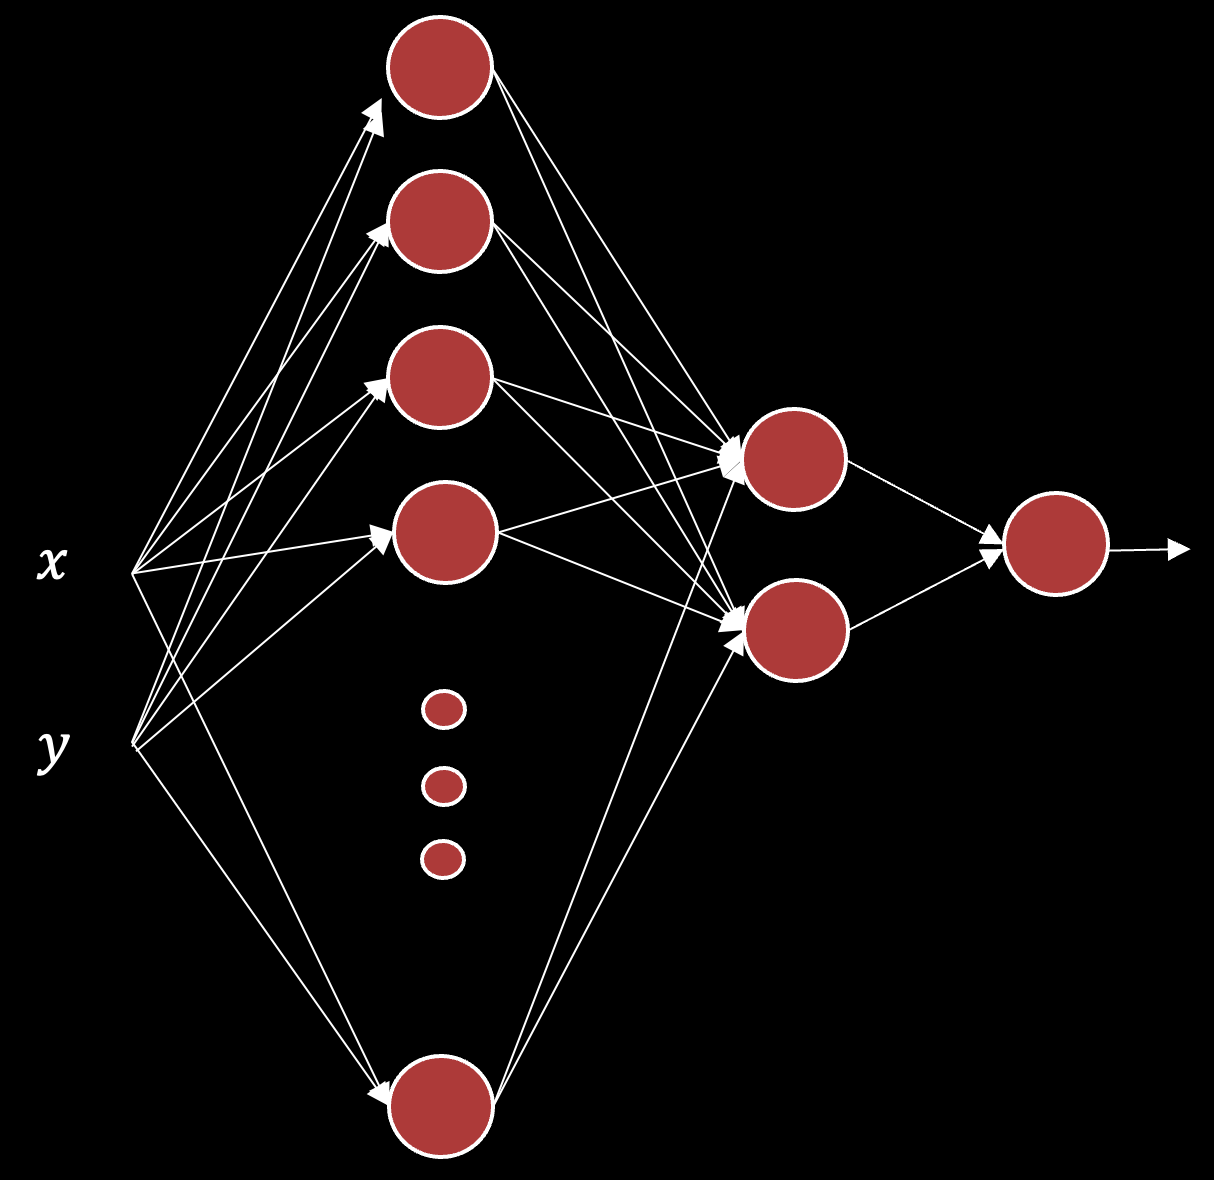

We saw that 50 neurons is good enough to solve this task, but ..

Let's see what happened when we have two output neurons aggregated to final output.

In [20]:
# Convert to torch tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

# ---- Define single-layer model: Logistic regression ----
class HidLayerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 50)
        self.linear2 = nn.Linear(50, 2)
        self.linear3 = nn.Linear(2, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.linear(x))
        x = self.activation(self.linear2(x))
        x = self.activation(self.linear3(x))

        return x

model = HidLayerNet()

# ---- Training setup ----
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# ---- Training loop ----
for epoch in range(30000):

    y_pred = model(X_tensor)

    loss = criterion(y_pred, y_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.4f}")


Epoch 0, Loss = 0.7461
Epoch 500, Loss = 0.6442
Epoch 1000, Loss = 0.6428
Epoch 1500, Loss = 0.6410
Epoch 2000, Loss = 0.6382
Epoch 2500, Loss = 0.6339
Epoch 3000, Loss = 0.6269
Epoch 3500, Loss = 0.6168
Epoch 4000, Loss = 0.6051
Epoch 4500, Loss = 0.5942
Epoch 5000, Loss = 0.5848
Epoch 5500, Loss = 0.5768
Epoch 6000, Loss = 0.5700
Epoch 6500, Loss = 0.5645
Epoch 7000, Loss = 0.5605
Epoch 7500, Loss = 0.5576
Epoch 8000, Loss = 0.5554
Epoch 8500, Loss = 0.5538
Epoch 9000, Loss = 0.5524
Epoch 9500, Loss = 0.5513
Epoch 10000, Loss = 0.5503
Epoch 10500, Loss = 0.5494
Epoch 11000, Loss = 0.5486
Epoch 11500, Loss = 0.5478
Epoch 12000, Loss = 0.5469
Epoch 12500, Loss = 0.5460
Epoch 13000, Loss = 0.5450
Epoch 13500, Loss = 0.5438
Epoch 14000, Loss = 0.5423
Epoch 14500, Loss = 0.5405
Epoch 15000, Loss = 0.5382
Epoch 15500, Loss = 0.5352
Epoch 16000, Loss = 0.5315
Epoch 16500, Loss = 0.5269
Epoch 17000, Loss = 0.5214
Epoch 17500, Loss = 0.5151
Epoch 18000, Loss = 0.5082
Epoch 18500, Loss = 0.501

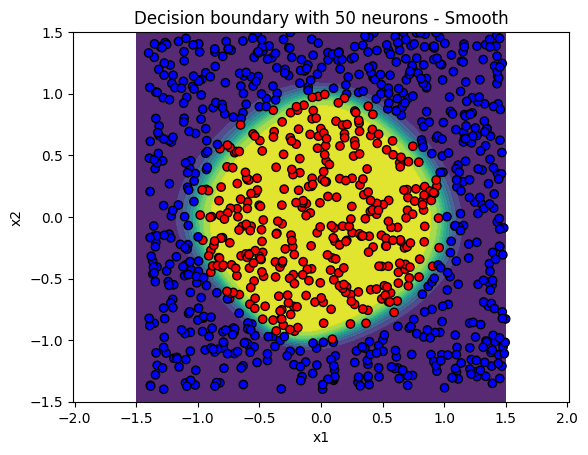

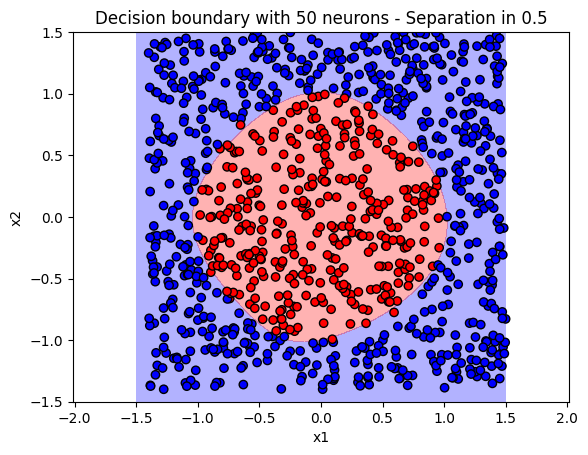

In [21]:
# ---- Plot decision boundary ----
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 200),
                     np.linspace(-1.5, 1.5, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)
zz = model(grid_tensor).detach().numpy().reshape(xx.shape)

plt.contourf(xx, yy, zz, levels=10, alpha=0.9)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap="bwr", edgecolor="k")
plt.title("Decision boundary with 50 neurons - Smooth")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

plt.contourf(xx, yy, zz, levels=[0,0.5,1], alpha=0.3, colors=["blue", "red"])
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap="bwr", edgecolor="k")
plt.title("Decision boundary with 50 neurons - Separation in 0.5")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

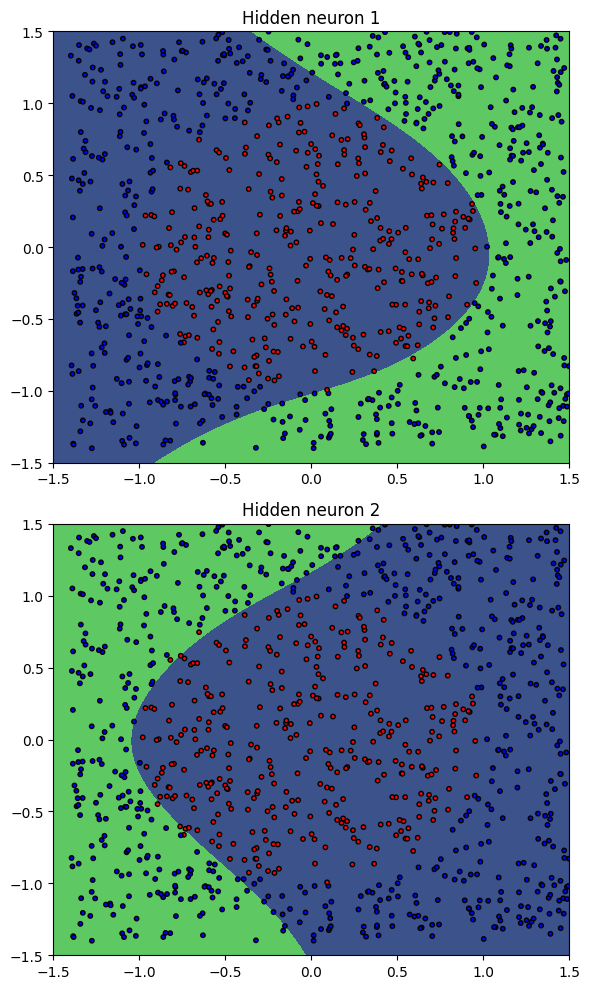

In [39]:

num_neurons = 2
rows, cols = 2, 1
fig, axes = plt.subplots(rows, cols, figsize=(6, 10)) # Adjusted width for 1 column

for i in range(num_neurons):
    # .flat handles the 1D array issue automatically
    ax = axes.flat[i]

        # Create a grid for visualization
    xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 200),
                         np.linspace(-1.5, 1.5, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Pass through the hidden layer
    hidden_1 = model.activation(model.linear(grid_tensor))
    hidden_vals = model.activation(model.linear2(hidden_1))[:, i].detach().numpy().reshape(xx.shape)

    # Use levels=20 or similar to see the activation gradient clearly
    im = ax.contourf(xx, yy, hidden_vals, levels=1, cmap='viridis')
    ax.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap="bwr", edgecolor='k', s=10)
    ax.set_title(f"Hidden neuron {i+1}")

plt.tight_layout()
plt.show()

# **Multi Layer Perceptron (MLP)**

## **MNIST - Hand Written Digit Classifier**

Lets build a full MLP Neural Network to clasify hand written digit images.

### **Load Data**

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.20MB/s]


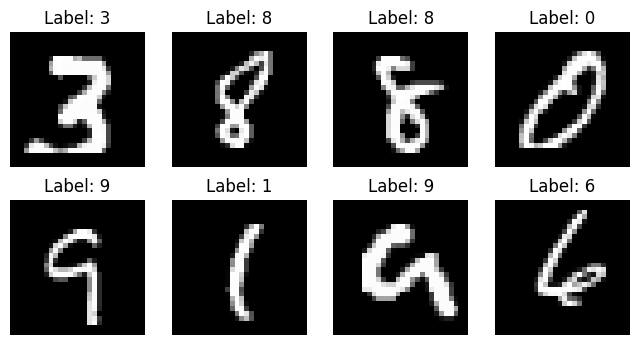

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

examples = iter(train_loader)
images, labels = next(examples)

plt.figure(figsize=(8, 4))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(f"Label: {labels[i].item()}")
    plt.axis("off")

plt.show()

### **Initialize Parameters & Hyperparameters**

In [4]:
input_size = 28 * 28   # MNIST images are 28x28
hidden1 = 64
hidden2 = 64
num_classes = 10
num_epochs = 5
learning_rate = 0.001

### **Create Model**

In [5]:
class MLP(nn.Module):
    def __init__(self, hidden1, hidden2, num_classes):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

model = MLP(hidden1 = hidden1, hidden2 = hidden2, num_classes = num_classes)

### **Loss & Optimizer**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### **Training**

Epoch [1/5], Loss: 0.2381, Test Accuracy: 93.52%
Epoch [2/5], Loss: 0.1790, Test Accuracy: 94.70%
Epoch [3/5], Loss: 0.1520, Test Accuracy: 95.56%
Epoch [4/5], Loss: 0.1323, Test Accuracy: 95.81%
Epoch [5/5], Loss: 0.1155, Test Accuracy: 95.82%


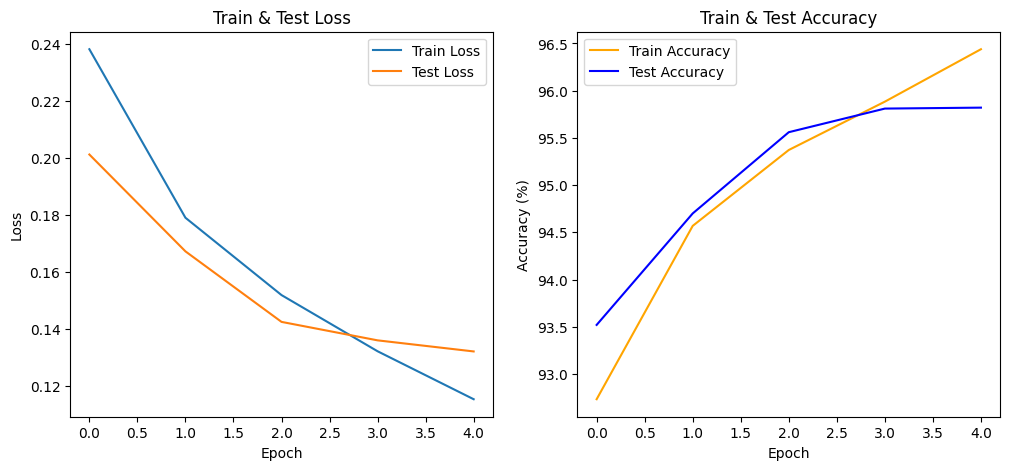

In [ ]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    # -------------------
    # Training phase
    # -------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    accuracy = 100 * correct / total
    train_accuracies.append(accuracy)

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # -------------------
    # Validation phase
    # -------------------
    model.eval()
    correct = 0
    total = 0
    test_loss_run = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            test_loss = criterion(outputs, labels)
            test_loss_run += test_loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss_run / len(test_loader)
    test_losses.append(avg_test_loss)

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Loss: {avg_loss:.4f}, "
          f"Test Accuracy: {accuracy:.2f}%")

# -------------------



Epoch [1/5], Loss: 0.4448, Test Accuracy: 91.34%
Epoch [2/5], Loss: 0.2357, Test Accuracy: 93.68%
Epoch [3/5], Loss: 0.1802, Test Accuracy: 95.05%
Epoch [4/5], Loss: 0.1479, Test Accuracy: 95.39%
Epoch [5/5], Loss: 0.1311, Test Accuracy: 95.68%
Epoch [6/5], Loss: 0.1147, Test Accuracy: 96.25%
Epoch [7/5], Loss: 0.1051, Test Accuracy: 95.59%
Epoch [8/5], Loss: 0.0982, Test Accuracy: 96.25%
Epoch [9/5], Loss: 0.0884, Test Accuracy: 96.58%
Epoch [10/5], Loss: 0.0844, Test Accuracy: 96.56%
Epoch [11/5], Loss: 0.0784, Test Accuracy: 96.08%
Epoch [12/5], Loss: 0.0766, Test Accuracy: 96.84%
Epoch [13/5], Loss: 0.0685, Test Accuracy: 96.25%
Epoch [14/5], Loss: 0.0653, Test Accuracy: 97.12%
Epoch [15/5], Loss: 0.0617, Test Accuracy: 96.77%


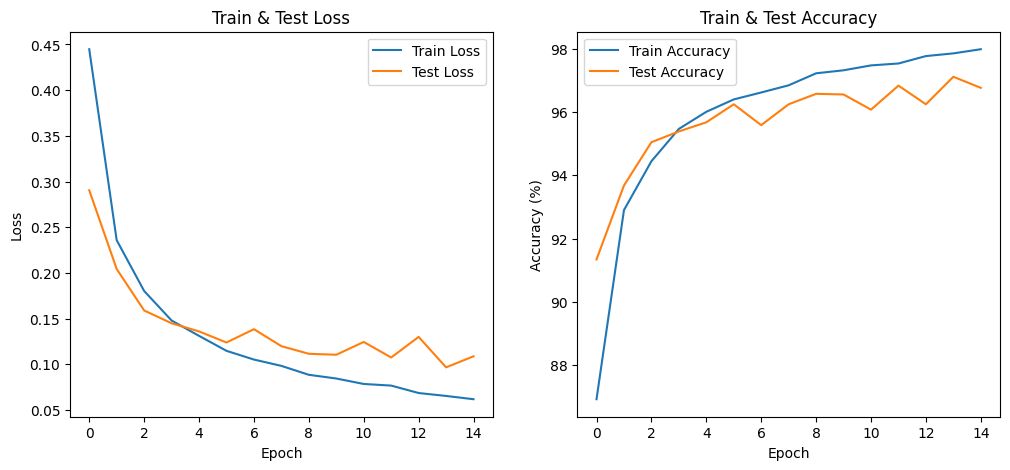

In [6]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

model = MLP(hidden1 = hidden1, hidden2 = hidden2, num_classes = num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


for epoch in range(15):
    # -------------------
    # Training phase
    # -------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    accuracy = 100 * correct / total
    train_accuracies.append(accuracy)

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # -------------------
    # Validation phase
    # -------------------
    model.eval()
    correct = 0
    total = 0
    test_loss_run = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            test_loss = criterion(outputs, labels)
            test_loss_run += test_loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss_run / len(test_loader)
    test_losses.append(avg_test_loss)

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Loss: {avg_loss:.4f}, "
          f"Test Accuracy: {accuracy:.2f}%")

# -------------------



plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train & Test Accuracy")
plt.legend()

plt.show()